# Introduction

We're going to run through one full calculation for the band structure of Silicon. We'll start off by optimizing the structure to minimize the forces, then refining the calculation, and finally running a calcluation for the band structure. 

# Setup

Let's start by setting up some imports for plotting, pretty printing, and file handling.

Then we'll make a temporary directory to work in

In [1]:
%matplotlib inline
import pprint
import shutil
import tarfile
import glob
import matplotlib

In [2]:
shutil.os.mkdir("Si_BandStructure")
shutil.os.chdir("Si_BandStructure")

# Building a VASP input set

In this section, we'll build a vasp input set by 'hand' using the structures in Pymatgen. All DFT codes have some sort of input deck or set. This tells the code the parameters of the calculations, the structure to work with, and any input data needed for the calculation. The VASP interface is the best developed since it is the code being used for the Materials Project.

A VASP input set consists of:
* POSCAR - the file that defines the structure
* POTCAR - the pseudopotentials that are used in the calculation
* INCAR - input commands that determine what kind of calcluation to run and to what tolerances
* KPOINTS - The recipricol space mesh that the calculations are run on

In [3]:
# Import a test structure
from pymatgen.util.testing import PymatgenTest 
struct_si = PymatgenTest.get_structure("Si")
print(struct_si)

Full Formula (Si2)
Reduced Formula: Si
abc   :   3.840198   3.840199   3.840198
angles: 119.999991  90.000000  60.000009
Sites (2)
  #  SP       a    b     c
---  ----  ----  ---  ----
  0  Si    0     0    0
  1  Si    0.75  0.5  0.75


In [4]:
# Build a POSCAR
from pymatgen.io.vasp.inputs import Poscar

Pos = Poscar(struct_si)
print(Pos)

Si2
1.0
3.840198 0.000000 0.000000
1.920099 3.325710 0.000000
0.000000 -2.217138 3.135509
Si
2
direct
0.000000 0.000000 0.000000 Si
0.750000 0.500000 0.750000 Si



In [5]:
from pymatgen.io.vasp.inputs import Kpoints

kp = Kpoints(struct_si)
kp = kp.automatic_gamma_density(struct_si,600)
print(kp)

pymatgen generated KPOINTS with grid density = 600 / atom
0
Gamma
8 8 8



In [6]:
from pymatgen.io.vasp.inputs import Potcar

pots = Potcar(["Si"])
print(pots)

 PAW_PBE Si 05Jan2001
 4.00000000000000000
 parameters from PSCTR are:
   VRHFIN =Si: s2p2
   LEXCH  = PE
   EATOM  =   103.0669 eV,    7.5752 Ry

   TITEL  = PAW_PBE Si 05Jan2001
   LULTRA =        F    use ultrasoft PP ?
   IUNSCR =        1    unscreen: 0-lin 1-nonlin 2-no
   RPACOR =    1.500    partial core radius
   POMASS =   28.085; ZVAL   =    4.000    mass and valenz
   RCORE  =    1.900    outmost cutoff radius
   RWIGS  =    2.480; RWIGS  =    1.312    wigner-seitz radius (au A)
   ENMAX  =  245.345; ENMIN  =  184.009 eV
   ICORE  =        2    local potential
   LCOR   =        T    correct aug charges
   LPAW   =        T    paw PP
   EAUG   =  322.069
   DEXC   =    -.007
   RMAX   =    2.944    core radius for proj-oper
   RAUG   =    1.300    factor for augmentation sphere
   RDEP   =    1.993    radius for radial grids
   QCUT   =   -4.246; QGAM   =    8.493    optimization parameters
 
   Description
     l     E      TYP  RCUT    TYP  RCUT
     0   .000     23  1.90

In [7]:
pots_lda = Potcar(['Si'],functional="LDA")
print(pots)

 PAW_PBE Si 05Jan2001
 4.00000000000000000
 parameters from PSCTR are:
   VRHFIN =Si: s2p2
   LEXCH  = PE
   EATOM  =   103.0669 eV,    7.5752 Ry

   TITEL  = PAW_PBE Si 05Jan2001
   LULTRA =        F    use ultrasoft PP ?
   IUNSCR =        1    unscreen: 0-lin 1-nonlin 2-no
   RPACOR =    1.500    partial core radius
   POMASS =   28.085; ZVAL   =    4.000    mass and valenz
   RCORE  =    1.900    outmost cutoff radius
   RWIGS  =    2.480; RWIGS  =    1.312    wigner-seitz radius (au A)
   ENMAX  =  245.345; ENMIN  =  184.009 eV
   ICORE  =        2    local potential
   LCOR   =        T    correct aug charges
   LPAW   =        T    paw PP
   EAUG   =  322.069
   DEXC   =    -.007
   RMAX   =    2.944    core radius for proj-oper
   RAUG   =    1.300    factor for augmentation sphere
   RDEP   =    1.993    radius for radial grids
   QCUT   =   -4.246; QGAM   =    8.493    optimization parameters
 
   Description
     l     E      TYP  RCUT    TYP  RCUT
     0   .000     23  1.90

In [8]:
from pymatgen.io.vasp.inputs import Incar

inc = Incar({'NELM': 100, # Max electronic self-consistency steps 
             'IBRION': 2, # Relax using conjugate gradient
             'LWAVE': False, # Don't write wave function to WAVECAR
             'ISMEAR': -5, # Tetrahedron method with Blochl corrections for partial occupancies
             'SIGMA': 0.05, # smearing width in eV
             'MAGMOM': [0.6, 0.6], # Initial magnetic moment
             'ENCUT': 520, # Cutoff energy for plane wave basis set
             'ISIF': 3, # Full degree of freedom and calcualte stress tensor
             u'EDIFF': 0.0001, # Allowed error in total energy
             'NSW': 99, # Max ionic steps
             'LREAL': 'Auto', # Automatically determine if projection done in real space or recipricol space
             'PREC': 'Accurate', # Accurate precision mode
             'ALGO': 'Fast', # Fast electronic minimization algorithm
             'ISPIN': 2, # spin polarized calculations
             'LORBIT': 11 # Write Density of States
            })
print(inc)

ALGO = Fast
EDIFF = 0.0001
ENCUT = 520
IBRION = 2
ISIF = 3
ISMEAR = -5
ISPIN = 2
LORBIT = 11
LREAL = Auto
LWAVE = False
MAGMOM = 2*0.6
NELM = 100
NSW = 99
PREC = Accurate
SIGMA = 0.05



# Pymatgen Input Sets 

In [9]:
from pymatgen.util.testing import PymatgenTest
from pymatgen.io.vasp.sets import MPRelaxSet


vis = MPRelaxSet(struct_si, force_gamma=True)

print(vis.poscar)
print(vis.kpoints)
print(vis.incar)
print(vis.potcar)
vis.write_input(".")

Si2
1.0
3.840198 0.000000 0.000000
1.920099 3.325710 0.000000
0.000000 -2.217138 3.135509
Si
2
direct
0.000000 0.000000 0.000000 Si
0.750000 0.500000 0.750000 Si

pymatgen generated KPOINTS with grid density = 619 / atom
0
Gamma
8 8 8

ALGO = Fast
EDIFF = 0.0001
ENCUT = 520
IBRION = 2
ICHARG = 1
ISIF = 3
ISMEAR = -5
ISPIN = 2
LORBIT = 11
LREAL = Auto
LWAVE = False
MAGMOM = 2*0.6
NELM = 100
NSW = 99
PREC = Accurate
SIGMA = 0.05

 PAW_PBE Si 05Jan2001
 4.00000000000000000
 parameters from PSCTR are:
   VRHFIN =Si: s2p2
   LEXCH  = PE
   EATOM  =   103.0669 eV,    7.5752 Ry

   TITEL  = PAW_PBE Si 05Jan2001
   LULTRA =        F    use ultrasoft PP ?
   IUNSCR =        1    unscreen: 0-lin 1-nonlin 2-no
   RPACOR =    1.500    partial core radius
   POMASS =   28.085; ZVAL   =    4.000    mass and valenz
   RCORE  =    1.900    outmost cutoff radius
   RWIGS  =    2.480; RWIGS  =    1.312    wigner-seitz radius (au A)
   ENMAX  =  245.345; ENMIN  =  184.009 eV
   ICORE  =        2    local

# Pretend to run VASP

In [10]:
# Place pre-run files in Si_BandStructure
files = shutil.os.listdir("../outputs/Si_Opt/")
for f in files:
    shutil.copy(shutil.os.path.join("../outputs/Si_Opt/",f),".")

# Parse outputs

In [11]:
from pymatgen.io.vasp.outputs import Vasprun

vrun = Vasprun("vasprun.xml")
vrun.as_dict()

{'elements': ['Si'],
 'has_vasp_completed': True,
 'hubbards': {},
 'input': {'crystal': {'@class': 'Structure',
   '@module': 'pymatgen.core.structure',
   'lattice': {'a': 3.840198,
    'alpha': 119.99998575375618,
    'b': 3.8401988456199767,
    'beta': 90.0,
    'c': 3.8401975990989055,
    'gamma': 60.00000728422766,
    'matrix': [[3.840198, 0.0, 0.0],
     [1.920099, 3.32571, 0.0],
     [0.0, -2.217138, 3.135509]],
    'volume': 40.04479226687761},
   'sites': [{'abc': [0.0, 0.0, 0.0],
     'label': 'Si',
     'species': [{'element': 'Si', 'occu': 1}],
     'xyz': [0.0, 0.0, 0.0]},
    {'abc': [0.75, 0.5, 0.75],
     'label': 'Si',
     'species': [{'element': 'Si', 'occu': 1}],
     'xyz': [3.840198, 1.5000000000986446e-06, 2.35163175]}]},
  'incar': {'ALGO': 'Fast',
   'EDIFF': 0.0001,
   'ENCUT': 520.0,
   'IBRION': 2,
   'ICHARG': 1,
   'ISIF': 3,
   'ISMEAR': -5,
   'ISPIN': 2,
   'KPOINT_BSE': [-1, 0, 0, 0],
   'LORBIT': False,
   'LREAL': 'Auto',
   'LWAVE': False,
   'M

# Running under custodian
What happens if a calculation fails?

In [12]:

from pymatgen.io.vasp.sets import MPStaticSet
static_vis = MPStaticSet.from_prev_calc(".")


filelist = glob.glob("*")
for f in filelist:
    shutil.os.remove(f)    

static_vis.write_input(".")

In [13]:
from custodian import Custodian
from custodian.vasp.handlers import VaspErrorHandler
from custodian.vasp.jobs import VaspJob
from custodian.vasp.validators import VasprunXMLValidator

handlers = [VaspErrorHandler()]
jobs = [VaspJob(vasp_cmd=["echo","hello"])]
validators = [VasprunXMLValidator()]

c = Custodian(handlers,jobs,validators)
c.run()

RuntimeError: 0 errors reached: (CustodianError(...), u'Validation failed: <custodian.vasp.validators.VasprunXMLValidator object at 0x10d1c4a90>'). Exited...

In [14]:
# Place pre-run files in Si_BandStructure
files = shutil.os.listdir("../outputs/Si_Static/")
for f in files:
    shutil.copy(shutil.os.path.join("../outputs/Si_Static/",f),".")
    
c.run()

[{u'corrections': [],
  u'job': {u'@class': 'VaspJob',
   u'@module': 'custodian.vasp.jobs',
   'auto_gamma': True,
   'auto_npar': True,
   'backup': True,
   'final': True,
   'gamma_vasp_cmd': None,
   'output_file': u'vasp.out',
   'settings_override': None,
   'suffix': u'',
   'vasp_cmd': ['echo', 'hello']}},
 {u'corrections': [],
  u'job': {u'@class': 'VaspJob',
   u'@module': 'custodian.vasp.jobs',
   'auto_gamma': True,
   'auto_npar': True,
   'backup': True,
   'final': True,
   'gamma_vasp_cmd': None,
   'output_file': u'vasp.out',
   'settings_override': None,
   'suffix': u'',
   'vasp_cmd': ['echo', 'hello']}}]

# NonSCF Calculation

In [15]:
from pymatgen.io.vasp.sets import MPNonSCFSet

files = shutil.os.listdir(".")
shutil.os.mkdir("temp")
for f in files:
    shutil.move(f,"temp/")

NonSCF_vis = MPNonSCFSet.from_prev_calc("./temp",mode="line",kpoints_line_density=20)
NonSCF_vis.write_input(".")

In [16]:
shutil.os.listdir(".")

['CHGCAR', 'INCAR', 'KPOINTS', 'POSCAR', 'POTCAR', 'temp']

# Lets Pretend to run vasp

In [17]:
files = shutil.os.listdir("../outputs/Si_NonSCF//")
for f in files:
    shutil.copy(shutil.os.path.join("../outputs/Si_NonSCF/",f),".")

# Plot the band structure

/Users/shyamd/codes/pymatgen/pymatgen/io/vasp/outputs.py:814: UserWarning: No POTCAR file with matching TITEL fields was found in /Users/shyamd/Dropbox/Presentations/MP-Workshop-2016/manual_wflow/Si_BandStructure
  " was found in {}".format(os.path.abspath(p)))


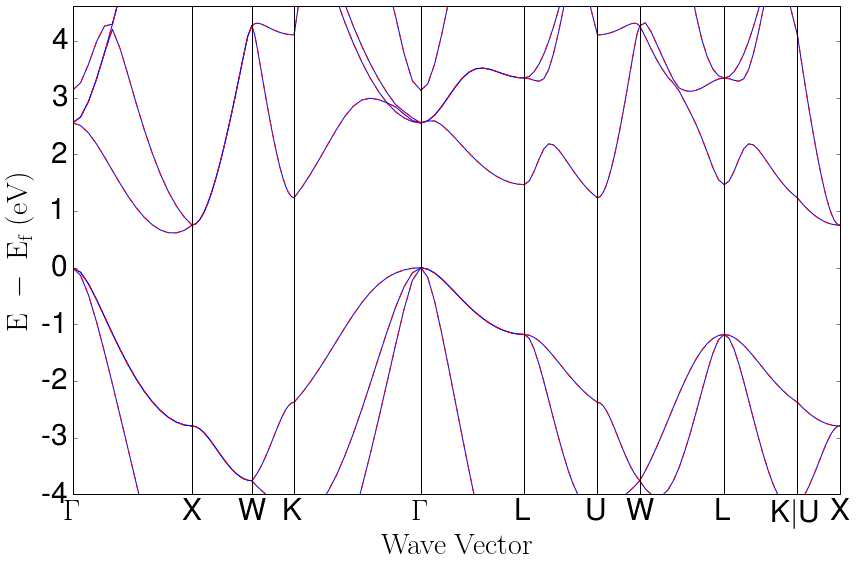

In [19]:
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import BSPlotter

vrun = Vasprun("vasprun.xml")
band_struc = vrun.get_band_structure()
bs_plotter = BSPlotter(band_struc)
bs_plotter.show()

In [21]:
band_struc.get_band_gap()

{'direct': False,
 'energy': 0.6143000000000001,
 'transition': u'\\Gamma-(0.433,0.000,0.433)'}

# Finalize

In [20]:
shutil.os.chdir("..")
shutil.rmtree("Si_BandStructure")